In [0]:
pip install sklearn_crfsuite


In [0]:
pip install eli5

In [0]:
#Data analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve,GridSearchCV
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#Data visualisation
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
import eli5
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
import nltk
from future.utils import iteritems
#Saving Model
import joblib


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#Utile fonctions

**word2features**
 define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [0]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,k, t) for w,k,t in zip(s["Word"].values.tolist(),
                                                           s["postag"].values.tolist(),
                                                           s["bio_tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])
    

def word2features(sent, i):
    word = str(sent[i][0])
    postag = sent[i][1]




    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'postag[:2]': postag[:2]
        
    }
    if i > 0:
        word1 = str(sent[i-1][0])
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2]
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = str(sent[i+1][0])
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2]
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

    



In [0]:
## To tag data with postag
def get_postag(word):
    pos_tag = nltk.tag.pos_tag([str(word)])
    return pos_tag[0][1]


# Apply CRF

In [0]:
#read data
data=pd.read_csv("Annotated_Intro.csv")
data=data.dropna()


In [0]:
data=data.drop(['Unnamed: 0'],axis=1)

In [0]:
data=data.drop(['Entity'],axis=1)

In [0]:
data

,Unnamed: 0.1,Sentence,Word,postag,bio_tag
0,0,2,Testicular,NN,B-DI
1,1,2,cancer,NN,I-DI
2,2,2,survivors,NNS,O
3,3,2,TCS,NN,O
4,4,2,increased,VBN,O
...,...,...,...,...,...
31478,31478,1064,incontinence,NN,I-SYMP
31479,31479,1064,result,NN,O
31480,31480,1064,radical,JJ,O
31481,31481,1064,prostatectomy,NN,O


**SIMPLE CRF**

In [0]:
getter = getsentence(data)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])

[('Testicular', 'NN', 'B-DI'), ('cancer', 'NN', 'I-DI'), ('survivors', 'NNS', 'O'), ('TCS', 'NN', 'O'), ('increased', 'VBN', 'O'), ('risk', 'NN', 'O'), ('treatment-related', 'JJ', 'O'), ('cardiovascular', 'NN', 'O'), ('disease', 'NN', 'O'), ('CVD', 'NN', 'O'), ('may', 'MD', 'O'), ('limit', 'NN', 'O'), ('overall', 'JJ', 'O'), ('survival.', 'NN', 'O'), ('We', 'PRP', 'O'), ('evaluated', 'VBN', 'O'), ('effects', 'NNS', 'O'), ('high-intensity', 'NN', 'B-NPI'), ('aerobic', 'NN', 'I-NPI'), ('interval', 'NN', 'I-NPI'), ('training', 'NN', 'I-NPI'), ('HIIt', 'NN', 'O'), ('traditional', 'JJ', 'B-NPI'), ('novel', 'NN', 'O'), ('CVD', 'NN', 'O'), ('risk', 'NN', 'O'), ('factors', 'NNS', 'O'), ('surrogate', 'NN', 'O'), ('markers', 'NNS', 'O'), ('mortality', 'NN', 'O'), ('population-based', 'JJ', 'O'), ('sample', 'NN', 'O'), ('TCS', 'NN', 'O'), ('.', '.', 'O')]


In [0]:
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

6083


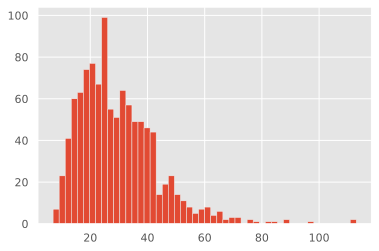

In [0]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [0]:
#Words tagged as B-NPI
data.loc[data['bio_tag'] == 'B-NPI', 'Word'].count()

3450

In [0]:
#Words tagged as B-DI
data.loc[data['bio_tag'] == 'B-DI', 'Word'].count()

1362

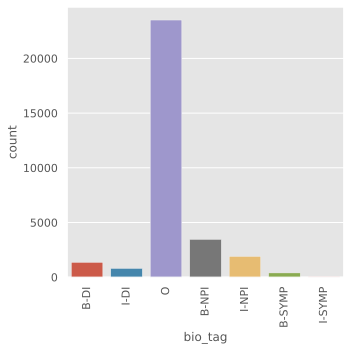

In [0]:
plt.figure(figsize=(5, 5))
ax = sns.countplot('bio_tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [0]:
#Simple feature map to feed arrays into the classifier. 
data['Word']=data['Word'].astype(str)
data['Sentence']=data['Sentence'].astype(str)
data['bio_tag']=data['bio_tag'].astype(str)
data['postag']=data['postag'].astype(str)




In [0]:
words = [feature_map(w) for w in data["Word"].tolist()]
tags = data["bio_tag"].values.tolist()

In [0]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

This is what word2features extracts:



In [0]:
X_train[0][1]

{'+1:postag': 'NN',
 '+1:postag[:2]': 'NN',
 '+1:word.istitle()': False,
 '+1:word.isupper()': True,
 '+1:word.lower()': 'crf',
 '-1:postag': 'JJ',
 '-1:postag[:2]': 'JJ',
 '-1:word.istitle()': False,
 '-1:word.isupper()': False,
 '-1:word.lower()': 'cancer-related',
 'bias': 1.0,
 'postag': 'NN',
 'postag[:2]': 'NN',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'fatigue',
 'word[-2:]': 'ue',
 'word[-3:]': 'gue'}

In [0]:
%%time
crf = CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)


CPU times: user 935 µs, sys: 0 ns, total: 935 µs
Wall time: 648 µs


In [0]:
crf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [0]:
pred = cross_val_predict(estimator=crf, X=X_test, y=y_test, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y_test)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


              precision    recall  f1-score   support

        B-DI       0.90      0.84      0.87       450
       B-NPI       0.79      0.57      0.66      1169
      B-SYMP       0.88      0.71      0.78       128
        I-DI       0.93      0.85      0.89       267
       I-NPI       0.75      0.50      0.60       602
      I-SYMP       1.00      0.55      0.71        20
           O       0.91      0.98      0.94      7723

    accuracy                           0.89     10359
   macro avg       0.88      0.72      0.78     10359
weighted avg       0.89      0.89      0.88     10359



In [0]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top likely transitions:
I-DI   -> I-DI    2.824125
I-SYMP -> I-SYMP  2.759566
B-DI   -> I-DI    2.719120
B-SYMP -> I-SYMP  2.622651
B-NPI  -> I-NPI   2.238205
I-NPI  -> I-NPI   2.146626
O      -> B-NPI   2.019958
O      -> O       1.970858
O      -> B-DI    1.003894
O      -> B-SYMP  0.940301

Top unlikely transitions:
I-DI   -> I-NPI   -2.716759
B-SYMP -> B-SYMP  -2.893583
B-SYMP -> I-NPI   -3.009545
O      -> I-DI    -3.015363
B-NPI  -> I-DI    -3.240741
I-DI   -> B-DI    -3.456446
B-DI   -> B-DI    -3.918431
O      -> I-NPI   -4.378524
I-NPI  -> B-NPI   -4.457324
B-NPI  -> B-NPI   -4.840726


In [0]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-0:]

**Evaluation**



In [0]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-SYMP', 'B-DI', 'I-DI', 'B-NPI', 'I-NPI', 'I-SYMP']

In [0]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.788986981246202

In [0]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

        B-DI      0.921     0.882     0.901       450
        I-DI      0.932     0.925     0.929       267
       B-NPI      0.843     0.680     0.753      1169
       I-NPI      0.788     0.616     0.692       602
      B-SYMP      0.890     0.883     0.886       128
      I-SYMP      1.000     0.700     0.824        20

   micro avg      0.861     0.735     0.793      2636
   macro avg      0.896     0.781     0.831      2636
weighted avg      0.856     0.735     0.789      2636



**Hyperparameter tuning using Randomized CV Search**

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

In [0]:
%%time
# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=5, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 14.0min finished


CPU times: user 11min 19s, sys: 1.05 s, total: 11min 20s
Wall time: 14min 2s


Best result:



In [0]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.09390653231360736, 'c2': 0.011903161978039973}
best CV score: 0.7792901360141461
model size: 0.46M


In [0]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))

**Check best estimator on our test data**


As we can see, quality is improved.

In [0]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

        B-DI      0.915     0.889     0.902       450
        I-DI      0.935     0.921     0.928       267
       B-NPI      0.841     0.708     0.769      1169
       I-NPI      0.772     0.601     0.676       602
      B-SYMP      0.890     0.883     0.886       128
      I-SYMP      1.000     0.700     0.824        20

   micro avg      0.855     0.745     0.796      2636
   macro avg      0.892     0.784     0.831      2636
weighted avg      0.851     0.745     0.793      2636



**This is what classifier learned**

In [0]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(5))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-5:])

Top likely transitions:
I-SYMP -> I-SYMP  3.008145
I-DI   -> I-DI    2.949871
B-SYMP -> I-SYMP  2.741453
B-DI   -> I-DI    2.640628
I-NPI  -> I-NPI   2.284021

Top unlikely transitions:
B-NPI  -> I-DI    -5.133631
I-DI   -> B-DI    -5.473776
O      -> I-NPI   -6.131229
I-NPI  -> B-NPI   -6.204489
B-NPI  -> B-NPI   -6.768960


In [0]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(50))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
10.827689 B-NPI    word.lower():screening
10.229671 B-NPI    word.lower():negative
10.054120 B-DI     word.lower():obesity
9.923531 B-NPI    word.lower():physical
9.471803 B-SYMP   word.lower():pain
9.366368 B-NPI    word.lower():dietary
8.828918 B-NPI    word.lower():protective
8.786146 B-NPI    word.lower():cognitive
8.705119 B-SYMP   word.lower():inflammation
8.508488 B-SYMP   word.lower():depression
8.345781 B-NPI    word.lower():activity
8.225567 B-NPI    word.lower():therapeutic
8.163516 B-NPI    word.lower():education
8.160016 B-NPI    word.lower():management
8.142728 B-NPI    word.lower():rate
8.077732 B-NPI    word.lower():intensity
8.047381 B-NPI    word.lower():reduction
8.008025 B-SYMP   word.lower():stress
7.987995 I-NPI    word.lower():activity
7.963868 B-NPI    word.lower():late
7.813272 B-NPI    word.lower():practices
7.499507 B-NPI    word.lower():counseling
7.301448 B-NPI    word.lower():vaginal
7.267072 B-NPI    word.lower():behaviors
7.262796 B-SYMP   

In [0]:
# save the model to disk
filename = '/content/drive/My Drive/CRFModels/CrfIntroduction.sav'
joblib.dump(crf, filename)
#  the model from disk
#crf1 = joblib.load(filename)
#result = crf1.score(X_test, y_test)
#print(result)

0.8599505707896905


In [0]:
eli5.show_weights(crf, top=30)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


**Interpretation:**
Les modèles CRFsuite CRF utilisent deux types de fonctionnalités : des fonctionnalités d'état et des fonctionnalités de transition
Les caractéristiques de transition ont un sens : au moins le modèle a appris que **I-ENITITY** doit suivre **B-ENTITY**.
On peut s'attendre à ce que les transitions O -> I-ENTITY aient un poids négatif important car elles sont impossibles.
Nous pouvons également constater que **B-DI -> I-DI** a des poids positifs, ce qui est logique, car les noms des maladies sont parfois composés, il en va de même pour les INM.


In [0]:
eli5.show_weights(crf, top=10, feature_re='^word\.is',
                  horizontal_layout=False, show=['targets'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Weight?,Feature
+0.309,word.isdigit()
-0.164,word.isupper()
-0.348,word.istitle()
Weight?,Feature
+1.089,word.isupper()
+0.787,word.istitle()
Weight?,Feature
-0.320,word.isupper()
-1.712,word.istitle()
Weight?,Feature


In [0]:
print("Sent:", sentences[26])
sent_f = sent2features(sentences[26])
print("Sent f shape:", len(sent_f), ", feats:", sent_f[15])
pred = crf.predict([sent_f])
print("Predicted:", pred)

Sent: [('Identifying', 'VBG', 'O'), ('high-risk', 'NN', 'O'), ('individuals', 'NNS', 'O'), ('melanoma', 'NN', 'B-DI'), ('education', 'NN', 'B-NPI'), ('risk', 'NN', 'O'), ('reduction', 'NN', 'B-NPI'), ('may', 'MD', 'O'), ('viable', 'JJ', 'O'), ('strategy', 'NN', 'O'), ('curb', 'NN', 'O'), ('incidence', 'NN', 'O'), ('melanoma', 'NN', 'B-DI'), ('risen', 'NN', 'O'), ('precipitously', 'RB', 'O'), ('past', 'NN', 'O'), ('50', 'CD', 'O'), ('years.', 'NN', 'O'), ('The', 'DT', 'O'), ('first-degree', 'JJ', 'O'), ('relatives', 'NNS', 'O'), ('melanoma', 'NN', 'B-DI'), ('patients', 'NNS', 'O'), ('represent', 'NN', 'O'), ('risk', 'NN', 'O'), ('group', 'NN', 'O'), ('may', 'MD', 'O'), ('experience', 'NN', 'O'), ('teachable', 'JJ', 'O'), ('moment', 'NN', 'O'), ('enhanced', 'VBN', 'O'), ('education', 'NN', 'B-NPI'), ('risk', 'NN', 'O'), ('reduction', 'NN', 'B-NPI'), ('.', '.', 'O')]
Sent f shape: 35 , feats: {'bias': 1.0, 'word.lower()': 'past', 'word[-3:]': 'ast', 'word[-2:]': 'st', 'word.isupper()': Fa



# Annotate text




**Load crf model**

In [0]:
# save the model to disk
filename = '/content/drive/My Drive/CRFModels/CrfConclusion.sav'
#  the model from disk
crfC = joblib.load(filename)



Annotate text with B-ENTITY AND I-ENTITY

In [0]:
from nltk.tokenize import sent_tokenize, word_tokenize 
import nltk
nltk.download('punkt')

Abstract='To examine the potential impact of elderly age on response to participation in a structured, multidisciplinary quality-of-life (QOL) intervention for patients with advanced cancer undergoing radiation therapy.'
text=word_tokenize(Abstract)
sentence =nltk.pos_tag(text)

list1=[]

Tagged_sent=""
#sent=""
print(sentence)
def pos_tag(sentence):
    sentence_features = [word2features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))

sentenceT= pos_tag(sentence)
print(sentenceT)
    
for index in range(len(sentence)):


  if sentenceT[index][1] in ['B-SYMP', 'B-DI', 'I-DI', 'B-NPI', 'I-NPI', 'I-SYMP']:

    Tagged_sent+= " "+sentenceT[index][0][0] +" ( "+sentenceT[index][1]+ " ) "
  else:

    Tagged_sent+=" "+sentenceT[index][0][0]
      
    list1.append(Tagged_sent)
 

In [0]:
Tagged_sent

' To examine the potential impact of elderly age on response to participation in a structured , multidisciplinary quality-of-life ( QOL ( B-NPI )  ) ( I-NPI )  intervention ( I-NPI )  for patients with advanced cancer ( B-DI )  undergoing radiation ( B-SYMP )  therapy .'

# Creating XML




**Loading Model**

In [0]:
crf_model_filename=""
Model_crf = joblib.load(crf_model_filename="")

In [0]:
def CRF_tag(sentence,crf):
    sentence_features = [word2features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))

**CreateXML is a function that annotate text with crf model and convert it to XML tags**

In [0]:
def CreateXML(Abstract,Model_crf):

  content = Abstract
  find=re.findall(r"[a-z0-9)%][.][A-Z]",content)

  if len(find)!=0:
      content=re.sub(r"([a-z0-9)%])[.]([A-Z])",r"\1. \2",content)
  #Tokenize the abstract
  text=word_tokenize(content)

  #Pos tag the abstract
  sentence =nltk.pos_tag(text)

  ## Tag the sentence with CRF
  sentenceT= CRF_tag(sentence,Model_crf)

  Tagged_sent=""

  ## For compound Tags eg. (B-NPI and I-NPI)
  compound=""


  for index in range(len(sentence)):


    
    if sentenceT[index][1] in ['B-SYMP', 'B-DI', 'B-NPI']:
      
      #if the I-ENTITY is followed with B-ENTITY
      if compound :
        Tagged_sent=Tagged_sent+compound+"</"+sentenceT[index-1][1][2:]+">"
        compound=""


      element = "<"+sentenceT[index][1][2:]+">"
      Tagged_sent+= element


      compound+=sentenceT[index][0][0]

      if not sentenceT[index+1][1] in ['I-SYMP', 'I-DI', 'I-NPI']:
            Tagged_sent+=sentenceT[index][0][0]+"</"+sentenceT[index][1][2:]+">"
            compound=""

    elif  sentenceT[index][1] in ['I-SYMP', 'I-DI', 'I-NPI']:

      compound+=" "+sentenceT[index][0][0]

    else:

      if compound :
        Tagged_sent=Tagged_sent+compound+"</"+sentenceT[index-1][1][2:]+">"
        compound=""


      Tagged_sent=Tagged_sent+ sentenceT[index][0][0]+" "
  
  return str(Tagged_sent)
      
  

In [0]:
Abstract='To examine the potential impact of elderly age on response to participation in a structured, multidisciplinary quality-of-life (QOL) intervention for patients with advanced cancer undergoing radiation therapy.'
Annotated_text=CreateXML(Abstract)
Annotated_text

'To examine the potential impact of elderly age on response to participation in a structured , multidisciplinary quality-of-life ( <NPI>QOL ) intervention</NPI>for patients with advanced <DI>cancer</DI>undergoing <SYMP>radiation</SYMP>therapy <DI>breast cancer</DI><NPI>vitamin x</NPI>hhD . '

# Reading from XML and creating NER dataset

In [0]:
#invoke libraries
from bs4 import BeautifulSoup
from bs4.element import Tag
import codecs
import nltk
from nltk import word_tokenize, pos_tag
from sklearn.model_selection import train_test_split
import pycrfsuite
import os, os.path, sys
import glob
from xml.etree import ElementTree
import numpy as np
from sklearn.metrics import classification_report

In [0]:
#this function appends all annotated files
def append_annotations(files):
    xml_files = glob.glob(files +"/*.xml")
    xml_element_tree = None
    new_data = ""
    for xml_file in xml_files:
        data = ElementTree.parse(xml_file).getroot()
        print (ElementTree.tostring(data) )       
        temp = ElementTree.tostring(data)
        new_data += (str(temp))
    return(new_data)

#this function removes special characters and punctuations
def remov_punct(withpunct):
    punctuations = '''!-[]{};:'"\,<>/?@#$%^&*_~'''
    without_punct = ""
    char = 'nan'
    for char in withpunct:
        if char not in punctuations:
            without_punct = without_punct + char
    return(without_punct)

# functions for extracting features in documents
def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]

def get_labels(doc):
    return [label for (token, postag, label) in doc]

In [0]:

#/content/drive/My Drive/Gate Annotation/Abstracts

files_path = "/content/drive/My Drive/Abstractttt/"

allxmlfiles = append_annotations(files_path)
soup = bs(allxmlfiles, "html5lib")

#identify the tagged element
docs = []
sents = []

for d in soup.find_all("paragraph"):
   for wrd in d.contents:    
    tags = []
    NoneType = type(None)   
    if isinstance(wrd.name, NoneType) == True:
        withoutpunct = remov_punct(wrd)
        temp = word_tokenize(str(withoutpunct))
        for token in temp:
            tags.append((token,'O'))            
    else:
        withoutpunct = remov_punct(wrd)
        temp = word_tokenize(str(withoutpunct))
        for token in temp:
            tags.append((token,(wrd.name).upper()))    
    sents = sents + tags 
   docs.append(sents) #appends all the individual documents into one list

b'<paragraph>27784460,Introduction: To evaluate the effect of <NPI>traditional Chinese medicine</NPI> (TCM) treatment as maintenance therapy on regulating the serum concentration of soluble cytotoxic T lymphocyte associated antigen-4 (sCTLA-4) in patients with advanced non-small-cell <DI>lung cancer</DI> (<DI>NSCLC</DI>) and the relationship between sCTLA-4 and time to progression (TTP). \nMethods: This study was conducted as a prospective, randomized, controlled trial. 64 non-progressive patients who responded to initial therapy were randomized 1&#8758;1 to the TCM arm (treated with cinobufacini injection, <NPI>herbal decoction</NPI> and <NPI>Chinese acupoint</NPI> application, n=32) or to the chemotherapy arm (n=32). Each cycle was 21 days. Cycles were repeated until disease progression, unacceptable toxicity, or until the patient requested therapy discontinuation.The serum concentration of sCTLA-4 was detected by enzyme linked immunosorbent assay (ELISA) in the 64 patients with adva

In [0]:
docs[0]

[('27784460Introduction', 'O'),
 ('To', 'O'),
 ('evaluate', 'O'),
 ('the', 'O'),
 ('effect', 'O'),
 ('of', 'O'),
 ('traditional', 'NPI'),
 ('Chinese', 'NPI'),
 ('medicine', 'NPI'),
 ('(', 'O'),
 ('TCM', 'O'),
 (')', 'O'),
 ('treatment', 'O'),
 ('as', 'O'),
 ('maintenance', 'O'),
 ('therapy', 'O'),
 ('on', 'O'),
 ('regulating', 'O'),
 ('the', 'O'),
 ('serum', 'O'),
 ('concentration', 'O'),
 ('of', 'O'),
 ('soluble', 'O'),
 ('cytotoxic', 'O'),
 ('T', 'O'),
 ('lymphocyte', 'O'),
 ('associated', 'O'),
 ('antigen4', 'O'),
 ('(', 'O'),
 ('sCTLA4', 'O'),
 (')', 'O'),
 ('in', 'O'),
 ('patients', 'O'),
 ('with', 'O'),
 ('advanced', 'O'),
 ('nonsmallcell', 'O'),
 ('lung', 'DI'),
 ('cancer', 'DI'),
 ('(', 'O'),
 ('NSCLC', 'DI'),
 (')', 'O'),
 ('and', 'O'),
 ('the', 'O'),
 ('relationship', 'O'),
 ('between', 'O'),
 ('sCTLA4', 'O'),
 ('and', 'O'),
 ('time', 'O'),
 ('to', 'O'),
 ('progression', 'O'),
 ('(', 'O'),
 ('TTP', 'O'),
 (')', 'O'),
 ('.', 'O'),
 ('nMethods', 'O'),
 ('This', 'O'),
 ('study',